In [451]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet

import warnings                               
warnings.filterwarnings('ignore')

# Feature Engineering

In [452]:
df=pd.read_csv("train.csv")
df.head()

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-01-01 06:20:00+00:00,26.212347,28.696304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.00,3.976499,NaN,NaN,252.00,3.042750
1,2018-01-01 06:40:00+00:00,59.632658,29.052567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,11.091660,NaN,NaN,255.00,3.424814
2,2018-01-01 06:50:00+00:00,40.889650,28.984758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.75,4.234497,NaN,NaN,264.75,3.507172
3,2018-01-01 10:40:00+00:00,34.398111,30.282058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.75,5.347792,NaN,NaN,283.75,3.442212
4,2018-01-01 12:00:00+00:00,29.797653,29.333519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,6.022326,NaN,NaN,274.00,3.031363


In [453]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 06:20:00+00:00,26.212347,28.696304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.00,3.976499,NaN,NaN,252.00,3.042750
2018-01-01 06:40:00+00:00,59.632658,29.052567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,11.091660,NaN,NaN,255.00,3.424814
2018-01-01 06:50:00+00:00,40.889650,28.984758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.75,4.234497,NaN,NaN,264.75,3.507172
2018-01-01 10:40:00+00:00,34.398111,30.282058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.75,5.347792,NaN,NaN,283.75,3.442212
2018-01-01 12:00:00+00:00,29.797653,29.333519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,6.022326,NaN,NaN,274.00,3.031363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15 23:10:00+00:00,272.852287,23.500851,43.740629,-0.524250,-0.108540,-0.108540,63.668076,56.801410,1029.697556,64.904780,64.000634,35.012077,35.406250,182.00,54.889963,9.243551,2.0,182.00,5.156629
2020-03-15 23:20:00+00:00,295.675931,23.409183,43.529209,-0.684376,-0.168882,-0.168882,63.361840,56.551527,1032.996150,64.109157,63.189782,35.004216,35.280933,182.00,60.673948,9.269149,2.0,182.00,5.257433
2020-03-15 23:30:00+00:00,295.127333,23.336964,43.331115,-0.743521,-0.292512,-0.292512,63.156279,56.393276,1031.935870,63.740245,62.798514,35.003815,35.140925,182.00,59.551241,9.252811,2.0,182.00,5.188531


In [454]:
# df = df.fillna(df.mean())
# df.isna().sum()

# Fill missing values in all numerical columns with mean
# numeric_columns = df.select_dtypes(include=['number']).columns
# df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
# df = df.fillna(df.mean())


In [455]:

df = df.resample('D').mean()
df

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,366.223561,25.528849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.727612,74.042120,NaN,NaN,276.727612,5.263797
2018-01-02 00:00:00+00:00,462.550740,25.357526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.105603,93.555723,NaN,NaN,274.105603,5.390719
2018-01-03 00:00:00+00:00,454.417752,24.379363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.369130,91.627843,NaN,NaN,286.369130,5.295225
2018-01-04 00:00:00+00:00,369.952190,24.912347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,284.445471,74.360621,NaN,NaN,284.445471,5.094994
2018-01-05 00:00:00+00:00,319.446595,23.535679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292.013293,64.366148,NaN,NaN,292.013293,4.915224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-11 00:00:00+00:00,466.289248,28.276232,44.059155,0.482881,0.934002,0.934002,64.106761,56.921031,1163.017505,67.939614,67.174603,38.635532,39.955577,183.729298,71.852813,10.420975,2.030612,183.729298,5.385570
2020-03-12 00:00:00+00:00,570.315539,29.094133,44.476550,1.206977,1.629283,1.629283,64.051326,56.194520,1217.638162,70.008635,69.288543,39.978688,40.757739,180.773250,84.040654,10.931663,2.033333,180.773250,5.693483
2020-03-13 00:00:00+00:00,619.637333,30.088163,45.903233,2.168904,2.609776,2.609776,65.348205,57.663415,1213.959374,72.745844,72.096953,39.562485,41.600482,187.621975,99.693231,10.884414,2.059259,187.621975,5.765318


In [456]:
df = df.fillna(df.mean())


In [457]:
len(df)
# df=df.dropna()

805

In [458]:
missing_values = df['ActivePower'].isnull().sum()
infinite_values = not np.isfinite(df['ActivePower']).all()

print(f'Missing Values: {missing_values}')
print(f'Infinite Values: {infinite_values}')

Missing Values: 0
Infinite Values: False


In [459]:
history, test = df[:-15],df[-15:]

In [460]:
history = history.fillna(history.mean())
test = test.fillna(test.mean())

In [461]:
len(history), len(test)

(790, 15)

In [462]:
missing_values = history['ActivePower'].isnull().sum()
infinite_values = not np.isfinite(history['ActivePower']).all()

print(f'Missing Values: {missing_values}')
print(f'Infinite Values: {infinite_values}')


Missing Values: 0
Infinite Values: False


In [463]:
# history['ActivePower'].fillna(history['ActivePower'].mean(), inplace=True)
# len(history)

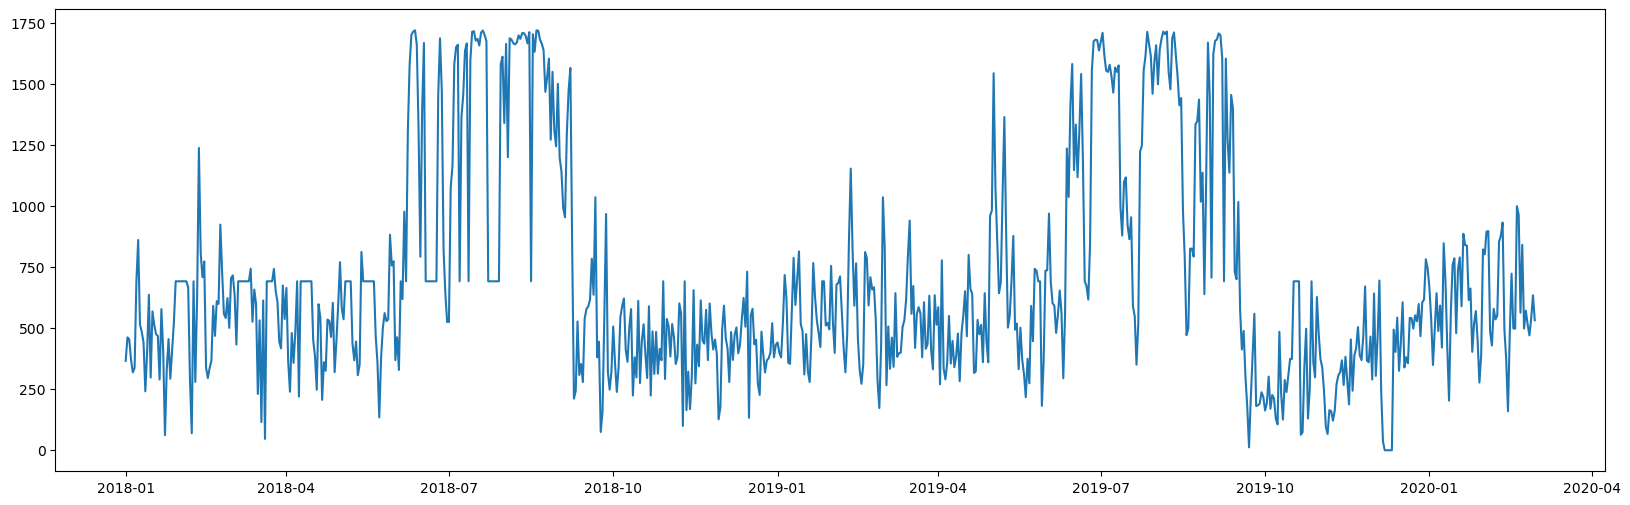

In [464]:
plt.figure(figsize=(20, 6))
plt.plot(history['ActivePower'])

<Figure size 3000x1000 with 0 Axes>

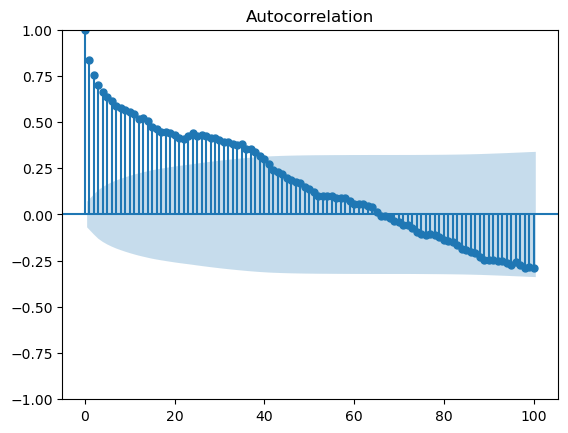

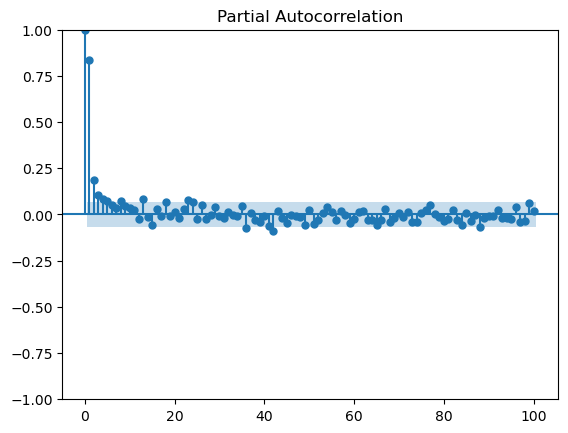

In [465]:
#visualize the data
plt.figure(figsize=(30, 10))
plot_acf(history['ActivePower'],lags=100)
plt.show()

plot_pacf(history['ActivePower'],lags=100)
plt.show()

In [466]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
adf_test(history['ActivePower'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.876438
p-value                          0.002215
#Lags Used                       7.000000
Number of Observations Used    782.000000
Critical Value (1%)             -3.438740
Critical Value (5%)             -2.865243
Critical Value (10%)            -2.568742
dtype: float64


- Stationary

# SARIMAX

In [467]:
def evaluate_models_cv_sarimax(dataset,exog, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    K=5
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p,d,q)
                            seasonal_order = (P,D,Q,m)
                            cfg = [(p,d,q), (P,D,Q,m)]
                            validation_size=15
                            train_size=len(dataset)-validation_size*K
                            rmse=0
                            for k in range(0,5):
                                train, test = dataset[0:train_size+k*validation_size],dataset[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                exog_train, exog_test = exog[0:train_size+k*validation_size],exog[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                model = sm.tsa.SARIMAX(train, order=trend_order, seasonal_order=seasonal_order, exog=exog_train) #each step: rolling one step forward to update the train se
                                model_fit = model.fit(disp=False)
                                predictions=model_fit.forecast(validation_size,exog=exog_test)
                                rmse = rmse+np.sqrt(skmetrics.mean_squared_error(test, predictions))
                            rmse_avg=rmse/3
                            result.append((cfg, rmse_avg))
                            if rmse_avg < best_rmse:
                                best_rmse, best_cfg = rmse_avg, cfg
                                print('SARIMAX%s RMSE=%.3f' % (cfg,rmse_avg))
    print('Best SARIMAX%s RMSE=%.3f' % (best_cfg, best_rmse))
    

In [468]:
# order selection
p=[0,1]
d=[1]
q=[0,1,2,5]
P=[1]
D=[0]
Q=[1]
m=12
evaluate_models_cv_sarimax(history['ActivePower'],history[['WindSpeed','RotorRPM']], p,d,q,P,D,Q,m)

SARIMAX[(0, 1, 0), (1, 0, 1, 12)] RMSE=108.722
SARIMAX[(0, 1, 1), (1, 0, 1, 12)] RMSE=78.062
SARIMAX[(0, 1, 5), (1, 0, 1, 12)] RMSE=74.415
SARIMAX[(1, 1, 5), (1, 0, 1, 12)] RMSE=73.577
Best SARIMAX[(1, 1, 5), (1, 0, 1, 12)] RMSE=73.577


# PROPHET

In [469]:

# df = pd.read_csv('DailyDelhiClimateTrain.csv')
# # plt.plot(df)
# df.dtypes
df.reset_index(inplace=True)

df['ds']=pd.to_datetime(df['Datetime'])
df['y']=df['ActivePower']
df=df[['ds','y']]
df['ds'] = df['ds'].dt.strftime('%Y-%m-%d')

# df=df[0:-15]

In [470]:
df

,ds,y
0,2018-01-01,366.223561
1,2018-01-02,462.550740
2,2018-01-03,454.417752
3,2018-01-04,369.952190
4,2018-01-05,319.446595
...,...,...
800,2020-03-11,466.289248
801,2020-03-12,570.315539
802,2020-03-13,619.637333
803,2020-03-14,800.312824


In [471]:
#Prophet project
m = Prophet()

#Fit with default settings
m.fit(df)
#Fataframe with forecasting steps
future = m.make_future_dataframe(periods=15)
#Forecast
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

11:15:47 - cmdstanpy - INFO - Chain [1] start processing
11:15:47 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
815,2020-03-26,566.151252,233.697609,883.811187
816,2020-03-27,522.729988,182.198220,857.524415
817,2020-03-28,522.845240,171.432513,842.009274
818,2020-03-29,502.383029,195.779198,833.201988
819,2020-03-30,503.294723,173.064929,848.230428


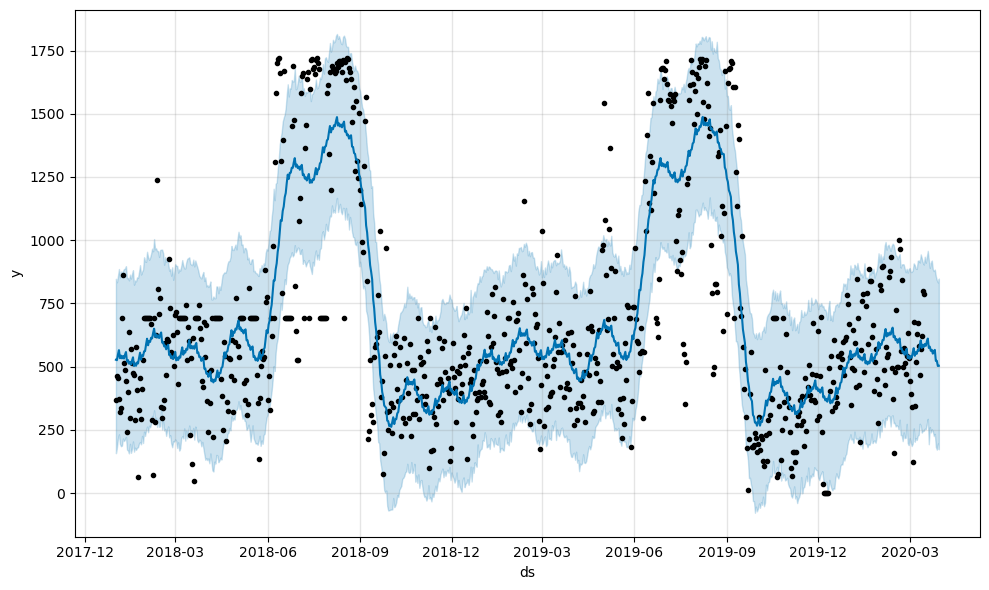

In [472]:
fig1 = m.plot(forecast)

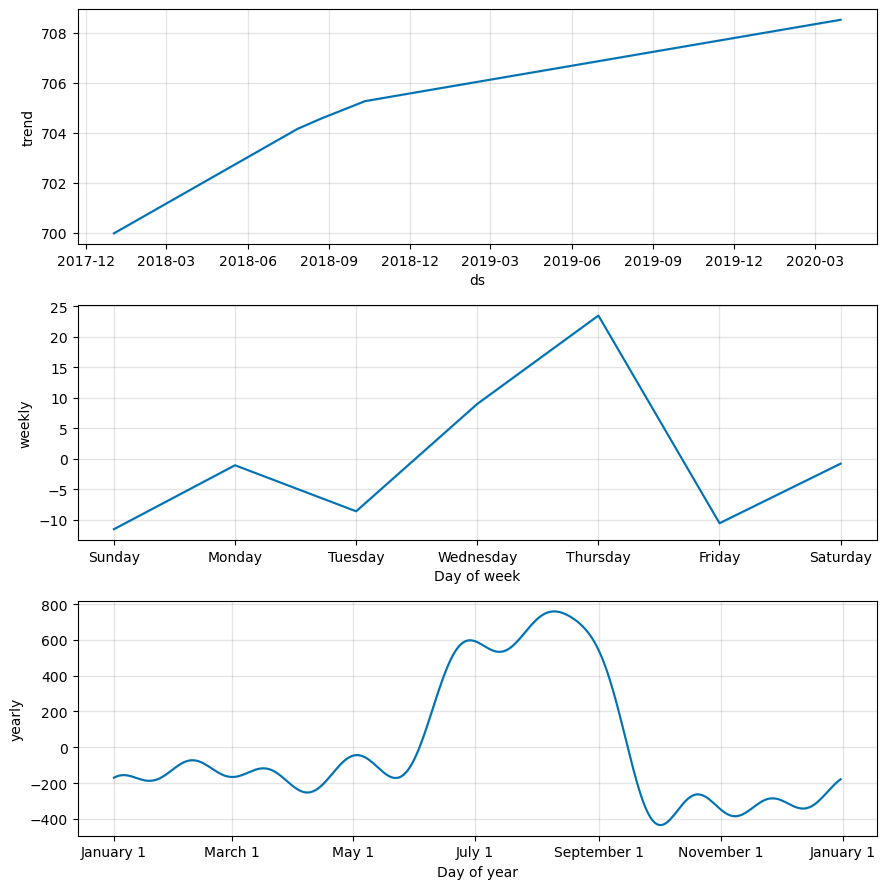

In [473]:
fig2 = m.plot_components(forecast)

In [474]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='789 days', period='15 days', horizon = '15 days')


  0%|          | 0/1 [00:00<?, ?it/s]

11:15:48 - cmdstanpy - INFO - Chain [1] start processing
11:15:48 - cmdstanpy - INFO - Chain [1] done processing


In [475]:
#check performance 

from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv) #by default start with 10% of the horizon
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,11049.298438,105.115643,105.115643,0.237250,0.237250,0.212091,1.0
1,2 days,29280.603107,171.115759,171.115759,0.438728,0.438728,0.359800,1.0
2,3 days,46062.923262,214.622746,214.622746,0.629146,0.629146,0.478593,1.0
3,4 days,207878.209119,455.936628,455.936628,3.726526,3.726526,1.301496,0.0
4,5 days,7651.083618,87.470473,87.470473,0.129223,0.129223,0.138150,1.0
5,6 days,46080.385903,214.663425,214.663425,0.621529,0.621529,0.474173,1.0
6,7 days,2829.367096,53.191795,53.191795,0.102950,0.102950,0.097910,1.0
7,8 days,4522.994894,67.253215,67.253215,0.106845,0.106845,0.112875,1.0
8,9 days,9110.841885,95.450730,95.450730,0.141719,0.141719,0.152527,1.0
9,10 days,46.153393,6.793629,6.793629,0.011682,0.011682,0.011751,1.0


In [476]:
# print(f'Prophet RMSE:', (np.sum(np.sqrt(mean_squared_error(forecast['yhat'][-15:], test['ActivePower'][-15:])) / test['ActivePower'].shape[0])))


In [477]:
len(forecast['yhat'][-15:])

15

In [478]:
forecast['ds'][-15:]

805   2020-03-16
806   2020-03-17
807   2020-03-18
808   2020-03-19
809   2020-03-20
810   2020-03-21
811   2020-03-22
812   2020-03-23
813   2020-03-24
814   2020-03-25
815   2020-03-26
816   2020-03-27
817   2020-03-28
818   2020-03-29
819   2020-03-30
Name: ds, dtype: datetime64[ns]

In [479]:
# df['date_column'] = pd.to_datetime(df['date_column'], errors='coerce').dt.tz_localize('UTC')

forecast['ds'] = pd.to_datetime(forecast['ds'], errors='coerce').dt.tz_localize('UTC')
df['ds'] = pd.to_datetime(df['ds'], errors='coerce').dt.tz_localize('UTC')

In [480]:
df['ds']

0     2018-01-01 00:00:00+00:00
1     2018-01-02 00:00:00+00:00
2     2018-01-03 00:00:00+00:00
3     2018-01-04 00:00:00+00:00
4     2018-01-05 00:00:00+00:00
                 ...           
800   2020-03-11 00:00:00+00:00
801   2020-03-12 00:00:00+00:00
802   2020-03-13 00:00:00+00:00
803   2020-03-14 00:00:00+00:00
804   2020-03-15 00:00:00+00:00
Name: ds, Length: 805, dtype: datetime64[ns, UTC]

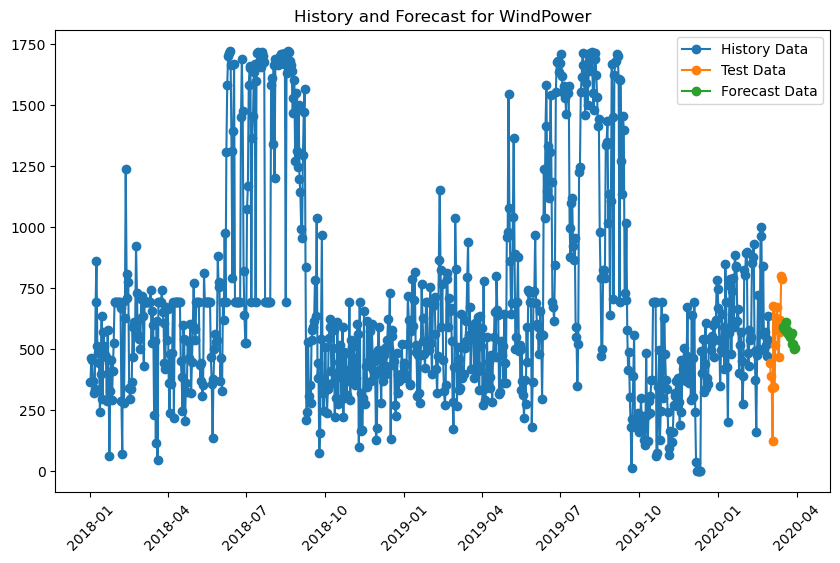

In [481]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df['ds'][:-15],df['y'][:-15], label='History Data', marker='o')
plt.plot(df['ds'][-15:],df['y'][-15:], label='Test Data', marker='o')
plt.plot(forecast['ds'][-15:],forecast['yhat'][-15:], label='Forecast Data', marker='o')
plt.xticks(rotation=45) 
# plt.xticks(np.arange(0,len(df), 50))
plt.title('History and Forecast for WindPower')  # Adding a title to the plot
plt.legend()